In [3]:
import pandas as pd
import numpy as np
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
pd.options.mode.chained_assignment = None  # 경고 숨기기

# 1. 최종 WordCloud

- 최종 전처리 된 데이터 불러오기

In [4]:
# 최종 전처리 완료된 데이터 불러오기
from google.colab import files

uploaded = files.upload()

news = pd.read_csv('naver_03.Preprocessing_FIN.csv')

news.head()

Saving naver_03.Preprocessing_FIN.csv to naver_03.Preprocessing_FIN.csv


,Date,Title,ppc_Title,Tokens,Stop_tokens
0,2023-06-01,"네이버, 금지·혐오 표현 기준 개정…12일부터 정책 적용",네이버 금지 혐오 표현 기준 개정 12일부터 정책 적용,"['네이버', '금지', '혐오', '표현', '기준', '개정', '정책', '적용']",금지 혐오 표현 기준 개정 정책 적용
1,2023-06-01,"네이버, 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유",네이버 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유,"['네이버', '거대', '상공인', '라이브', '커머스', '대본', '작성',...",거대 상공인 라이브 커머스 대본 작성 이유
2,2023-06-01,네이버 악성 댓글땐 ‘악플러 꼬리표’ 단다,네이버 악성 댓글땐 악플러 꼬리표 단다,"['네이버', '악성', '댓글', '때', '악플', '꼬리표']",악성 댓글 악플 꼬리표
3,2023-06-01,네이버가 4달간 중소상공인 브랜드 구축 돕는다,네이버가 4달간 중소상공인 브랜드 구축 돕는다,"['네이버', '중소', '상공인', '브랜드', '구축']",중소 상공인 브랜드 구축
4,2023-06-01,네이버·카카오 인물정보에 '장례지도사' 등 5개 직업 추가,네이버 카카오 인물정보에 장례지도사 등 5개 직업 추가,"['네이버', '카카오', '인물', '정보', '장례', '지도사', '직업', ...",카카오 인물 정보 장례 지도사 직업 추가


In [5]:
# 각 데이터프레임의 토큰을 하나의 문자열로 변환
news_data = ''
for _, row in news.iterrows():
    news_data += row['Stop_tokens']+ ' '
news_data

"['네이버', '금지', '혐오', '표현', '기준', '개정', '정책', '적용'] ['네이버', '거대', '상공인', '라이브', '커머스', '대본', '작성', '이유'] ['네이버', '악성', '댓글', '때', '악플', '꼬리표'] ['네이버', '중소', '상공인', '브랜드', '구축'] ['네이버', '카카오', '인물', '정보', '장례', '지도사', '직업', '추가'] ['현대차', '네이버', '하이퍼클로바X', '시장', '연착륙'] ['재난', '상황', '주연', '네이버', '공공', '인프라', '플랫폼', '책임'] ['웹툰', '논란', '네이버', '카카오', '인간', '작품'] ['네이버', '투자', '패션', '플랫폼', '브랜디', '자금', '수혈', '필요'] ['네이버', '마비', '복구', '재난'] ['트위터', '네이버', '사용', '실', '검', '부활'] ['김현철', '국정', '개입', '폭로', '의사', '네이버', '고소', '자료', '파기'] ['소년', '판타지', '네이버', '나우', '아베', '방송', '동시', '중계'] ['주치의', '네이버', '고소', '자료', '무단', '삭제'] ['발사체', '경보', '뒤', '네이버', '먹통', '시민', '혼란', '가중'] ['네이버', '계열사', '곳', '임금', '인상', '잠정', '합의'] ['포털', '위', '네이버', '뉴스', '개편', '언론사', '클릭', '장사', '격화', '우려'] ['네이버페이', '대출', '오픈', '금리', '포인트'] ['네이버', '검색', '순위', '조작', '은', '돈', '검찰'] ['네이버', '로켓', '배송', '네이버', '도착', '보장', '맘', '카페'] ['발사체', '네이버', '모바일', '접속', '장애'] ['원총', '네이버', '겨냥', '뉴스', '장사', '뉴스', '공정', '얘기', '때'] ['트리니티',

In [6]:
# 한글 폰트 다운로드 - Noto Sans CJK 폰트 설치
import subprocess
!apt-get update -qq
!apt-get install fonts-noto-cjk -qq

# 설치된 폰트 파일 경로 확인
font_path = subprocess.check_output('fc-list :lang=ko | grep "NotoSansCJK" | head -n 1', shell=True).decode().strip().split(':')[0]
# 한글 폰트 설정
path = f'{font_path}'
fontprop = fm.FontProperties(fname=path, size=12)

Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


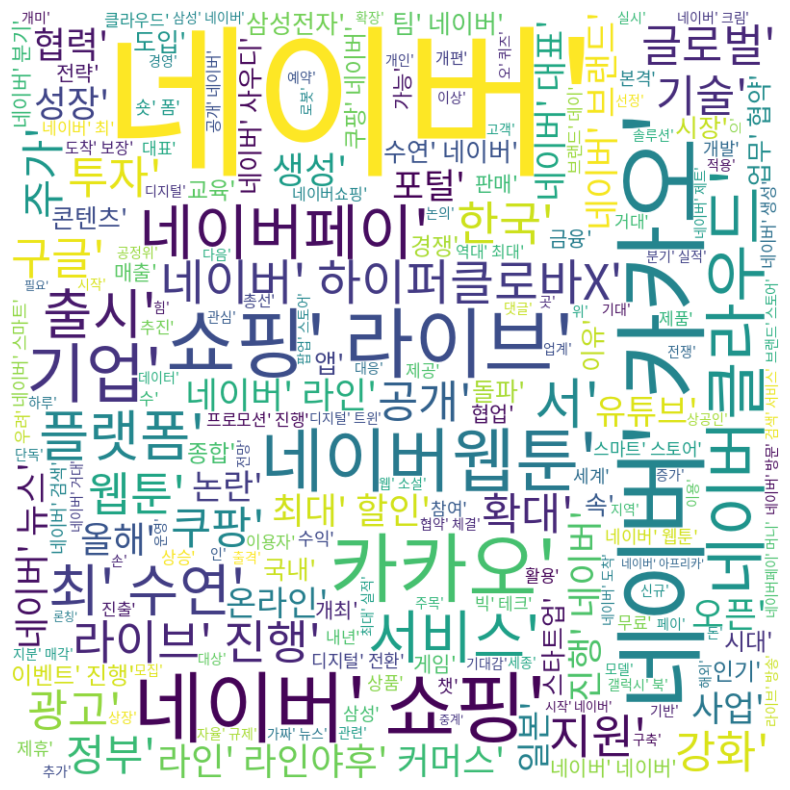

In [9]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(news_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_naver_02.png')

In [10]:
# 분석 결과
### 1. 카카오: 네이버와 함께 한국의 주요 IT 기업이므로. 동시에 언급되는 경우가 많음 => 두 회사가 비슷한 시장에서 경쟁하고 있으므로, 카카오의 주식 정보를 활용해봐도 좋을 듯
### 2. 네이버페이: 네이버의 결제 서비스로 네이버에서 영향력 있는 사업으로 추정됨
### 3. 서비스: '서비스'라는 단어가 많이 언급되어 있어, 네이버가 제공하는 다양한 서비스들이 뉴스의 주요 관심사임을 알 수 있습니다.
### 4. 공개: (서비스, 하이퍼클로바X, 기술, 디지털, 생성, 플랫폼) 등의 단어와 함께 새로운 서비스나 기술을 공개하는 기사가 많음을 알 수 있음 => 주식에 긍정 효과를 줄 것으로 예상 됨
### 5. 웹툰: 네이버의 웹툰 서비스가 많은 관심을 받는 만큼 영향이 있을 것으로 분석됨
### 6. 쇼핑 라이브, 네이버 쇼핑: 네이버의 쇼핑 플랫폼과 관련된 뉴스가 많음. 이 플랫폼에 협력한 기업들의 기사를 포함해서 다수의 기사가 있을 것으로 예상됨

# 2. 감정 분석

- 감정 사전 불러오기
(출처: # https://github.com/somijjjjj/BigOne)

In [11]:
# 감정 사전 데이터 불러오기
from google.colab import files

uploaded = files.upload()

word_dict_df = pd.read_csv("단어합본.csv")
word_dict_df = word_dict_df.drop(columns=['Unnamed: 0'])
word_dict = word_dict_df.set_index('word').to_dict()['polarity']

Saving 단어합본.csv to 단어합본.csv


### (1) 감정 사전 기반 계산

In [12]:
news.head()

,Date,Title,ppc_Title,Tokens,Stop_tokens
0,2023-06-01,"네이버, 금지·혐오 표현 기준 개정…12일부터 정책 적용",네이버 금지 혐오 표현 기준 개정 12일부터 정책 적용,"['네이버', '금지', '혐오', '표현', '기준', '개정', '정책', '적용']",금지 혐오 표현 기준 개정 정책 적용
1,2023-06-01,"네이버, 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유",네이버 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유,"['네이버', '거대', '상공인', '라이브', '커머스', '대본', '작성',...",거대 상공인 라이브 커머스 대본 작성 이유
2,2023-06-01,네이버 악성 댓글땐 ‘악플러 꼬리표’ 단다,네이버 악성 댓글땐 악플러 꼬리표 단다,"['네이버', '악성', '댓글', '때', '악플', '꼬리표']",악성 댓글 악플 꼬리표
3,2023-06-01,네이버가 4달간 중소상공인 브랜드 구축 돕는다,네이버가 4달간 중소상공인 브랜드 구축 돕는다,"['네이버', '중소', '상공인', '브랜드', '구축']",중소 상공인 브랜드 구축
4,2023-06-01,네이버·카카오 인물정보에 '장례지도사' 등 5개 직업 추가,네이버 카카오 인물정보에 장례지도사 등 5개 직업 추가,"['네이버', '카카오', '인물', '정보', '장례', '지도사', '직업', ...",카카오 인물 정보 장례 지도사 직업 추가


In [13]:
def find_sentiment_words(tokens, word_dict):
    pos_words = []
    neg_words = []
    zero_words = []
    sentiment_words = []

    total_polarity = 0

    for token in tokens.split():  # 각 단어를 공백 기준으로 분리
        if token in word_dict:
            sentiment_words.append(token)
            if word_dict[token] > 0:
                pos_words.append(token)
                total_polarity += word_dict[token]
            elif word_dict[token] < 0:
                neg_words.append(token)
                total_polarity += word_dict[token]
            else:
                zero_words.append(token)
        else:
            zero_words.append(token)

    return sentiment_words, pos_words, neg_words, zero_words, total_polarity

# 예제 데이터프레임과 word_dict를 사용하여 결과를 계산
sentiment_results = news['Stop_tokens'].apply(lambda x: find_sentiment_words(x, word_dict))

# 결과 출력
sentiment_results


0       ([금지, 혐오, 정책], [], [금지, 혐오], [표현, 기준, 개정, 정책, ...
1       ([거대, 이유], [거대], [], [상공인, 라이브, 커머스, 대본, 작성, 이...
2        ([악성, 댓글, 악플, 꼬리표], [], [악성, 악플, 꼬리표], [댓글], -5)
3                     ([구축], [구축], [], [중소, 상공인, 브랜드], 1)
4       ([카카오, 정보, 추가], [추가], [], [카카오, 인물, 정보, 장례, 지도...
                              ...                        
9305    ([협업, 강화, 시너지, 차별], [협업, 강화, 시너지], [차별], [티몬, ...
9306    ([카카오, 오픈], [오픈], [], [카카오, 라인, 라인야후, 해커, 채팅방,...
9307    ([꿈], [], [], [네이버웹툰, 꿈, 자유, 오디오, 웹툰, 텀, 블럭, 펀...
9308                  ([삼성], [], [], [삼성, 출신, 요즘, 국회], 0)
9309    ([대표, 올해, 서비스], [], [], [최, 수연, 대표, 올해, 서비스, 전...
Name: Stop_tokens, Length: 9310, dtype: object

In [14]:
news['Sentiment_Word'] = sentiment_results.apply(lambda x: ', '.join(x[0]))
news['Pos_Word'] = sentiment_results.apply(lambda x: ', '.join(x[1]))
news['Neg_Word'] = sentiment_results.apply(lambda x: ', '.join(x[2]))
news['Zero_Word'] = sentiment_results.apply(lambda x: ', '.join(x[3]))
news['Score'] = sentiment_results.apply(lambda x: x[4])
news

,Date,Title,ppc_Title,Tokens,Stop_tokens,Sentiment_Word,Pos_Word,Neg_Word,Zero_Word,Score
0,2023-06-01,"네이버, 금지·혐오 표현 기준 개정…12일부터 정책 적용",네이버 금지 혐오 표현 기준 개정 12일부터 정책 적용,"['네이버', '금지', '혐오', '표현', '기준', '개정', '정책', '적용']",금지 혐오 표현 기준 개정 정책 적용,"금지, 혐오, 정책",,"금지, 혐오","표현, 기준, 개정, 정책, 적용",-3
1,2023-06-01,"네이버, 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유",네이버 초거대 AI로 소상공인 라이브커머스 대본 작성 돕는 이유,"['네이버', '거대', '상공인', '라이브', '커머스', '대본', '작성',...",거대 상공인 라이브 커머스 대본 작성 이유,"거대, 이유",거대,,"상공인, 라이브, 커머스, 대본, 작성, 이유",1
2,2023-06-01,네이버 악성 댓글땐 ‘악플러 꼬리표’ 단다,네이버 악성 댓글땐 악플러 꼬리표 단다,"['네이버', '악성', '댓글', '때', '악플', '꼬리표']",악성 댓글 악플 꼬리표,"악성, 댓글, 악플, 꼬리표",,"악성, 악플, 꼬리표",댓글,-5
3,2023-06-01,네이버가 4달간 중소상공인 브랜드 구축 돕는다,네이버가 4달간 중소상공인 브랜드 구축 돕는다,"['네이버', '중소', '상공인', '브랜드', '구축']",중소 상공인 브랜드 구축,구축,구축,,"중소, 상공인, 브랜드",1
4,2023-06-01,네이버·카카오 인물정보에 '장례지도사' 등 5개 직업 추가,네이버 카카오 인물정보에 장례지도사 등 5개 직업 추가,"['네이버', '카카오', '인물', '정보', '장례', '지도사', '직업', ...",카카오 인물 정보 장례 지도사 직업 추가,"카카오, 정보, 추가",추가,,"카카오, 인물, 정보, 장례, 지도사, 직업",1
...,...,...,...,...,...,...,...,...,...,...
9305,2024-05-27,"티몬, 브랜드 단위 협업으로 직구 강화…""큐텐 시너지로 차별화""",티몬 브랜드 단위 협업으로 직구 강화 큐텐 시너지로 차별화,"['티몬', '브랜드', '단위', '협업', '직구', '강화', '큐', '텐'...",티몬 브랜드 단위 협업 직구 강화 큐 텐 시너지 차별,"협업, 강화, 시너지, 차별","협업, 강화, 시너지",차별,"티몬, 브랜드, 단위, 직구, 큐, 텐",2
9306,2024-05-27,"카카오·라인야후, 어떻게 해커에 뚫렸나… “오픈채팅방 ID 구조 단순”vs“...",카카오 라인야후 어떻게 해커에 뚫렸나 오픈채팅방 ID 구조 단순 VS,"['카카오', '라인', '라인야후', '해커', '오픈', '채팅방', '구조',...",카카오 라인 라인야후 해커 오픈 채팅방 구조 단순,"카카오, 오픈",오픈,,"카카오, 라인, 라인야후, 해커, 채팅방, 구조, 단순",1
9307,2024-05-27,네이버웹툰 ‘꿈에서 자유로’ 오는 6월 두 번째 오디오 웹툰 텀블럭 펀딩 실...,네이버웹툰 꿈에서 자유로 오는 6월 두 번째 오디오 웹툰 텀블럭 펀딩 실,"['네이버웹툰', '꿈', '자유', '오디오', '웹툰', '텀', '블럭', '...",네이버웹툰 꿈 자유 오디오 웹툰 텀 블럭 펀딩 실,꿈,,,"네이버웹툰, 꿈, 자유, 오디오, 웹툰, 텀, 블럭, 펀딩, 실",0
9308,2024-05-27,“삼성 출신 들어가니 좀 달라졌네”…요즘 국회는 ‘AI 열공’,삼성 출신 들어가니 좀 달라졌네 요즘 국회는 AI 열공,"['삼성', '출신', '요즘', '국회']",삼성 출신 요즘 국회,삼성,,,"삼성, 출신, 요즘, 국회",0


In [15]:
# CSV 파일로 저장
news.to_csv('naver_04.SentimentWord_01.csv', index=False)
# files.download('hybe_04.SentimentWord_01.csv')

---

# 3. 감정 별 WordColud

In [16]:
# # 잘 저장 됐는지 확인
# import pandas as pd
# news_check = pd.read_csv('naver_04.SentimentWord_01.csv')
# news_check.head()

news_check = copy.copy(news)
news_check = news_check[news_check['Score']==0]
news_check

,Date,Title,ppc_Title,Tokens,Stop_tokens,Sentiment_Word,Pos_Word,Neg_Word,Zero_Word,Score
5,2023-06-01,"현대차證 “네이버, 하이퍼클로바X 시장 연착륙할 것”",현대차證 네이버 하이퍼클로바X 시장 연착륙할 것,"['현대차', '네이버', '하이퍼클로바X', '시장', '연착륙']",현대차 하이퍼클로바X 시장 연착륙,"현대차, 시장",,,"현대차, 하이퍼클로바X, 시장, 연착륙",0
12,2023-06-01,"‘소년판타지’, MBC-네이버 나우-아베마(ABEMA), 127분 생방송 동시 중계",소년판타지 MBC 네이버 나우 아베마 ABEMA 127분 생방송 동시 중계,"['소년', '판타지', '네이버', '나우', '아베', '방송', '동시', '...",소년 판타지 나우 아베 방송 동시 중계,방송,,,"소년, 판타지, 나우, 아베, 방송, 동시, 중계",0
27,2023-06-01,오퀴즈 '에스트라 네이버 쇼핑 라이브' 8시 정답은?,오퀴즈 에스트라 네이버 쇼핑 라이브 8시 정답은,"['오', '퀴즈', '웨스트', '네이버', '쇼핑', '라이브', '정답']",오 퀴즈 웨스트 쇼핑 라이브 정답,정답,,,"오, 퀴즈, 웨스트, 쇼핑, 라이브, 정답",0
32,2023-06-01,"글로벌 3대 AI학회 논문수, 삼성 17위-네이버 18위 머물러",글로벌 3대 AI학회 논문수 삼성 17위 네이버 18위 머물러,"['글로벌', '학회', '논문', '수', '삼성', '네이버']",글로벌 학회 논문 삼성,"글로벌, 삼성",,,"글로벌, 학회, 논문, 삼성",0
38,2023-06-01,"[종합주가지수] 밀린 코스피, LG에너지솔루션·네이버 등 엇갈린 주가",밀린 코스피 LG에너지솔루션 네이버 등 엇갈린 주가,"['코스피', '에너지', '솔루션', '네이버', '주가']",코스피 에너지 솔루션 주가,"코스피, 주가",,,"코스피, 에너지, 솔루션, 주가",0
...,...,...,...,...,...,...,...,...,...,...
9301,2024-05-27,"시크(SEEC), 31일까지 네이버 가정의달 나들이용품 특가 위크 통해 '카시트·...",시크 SEEC 31일까지 네이버 가정의달 나들이용품 특가 위크 통해 카시트,"['시크', '네이버', '가정', '달', '나들이', '용품', '특가', '위...",시크 가정 달 나들이 용품 특가 위크 카 시트,,,,"시크, 가정, 달, 나들이, 용품, 특가, 위크, 카, 시트",0
9302,2024-05-27,한밤중 안양시에 혼자 움직이는 버스가 나타났다,한밤중 안양시에 혼자 움직이는 버스가 나타났다,"['밤중', '안양시', '버스']",밤중 안양시 버스,버스,,,"밤중, 안양시, 버스",0
9307,2024-05-27,네이버웹툰 ‘꿈에서 자유로’ 오는 6월 두 번째 오디오 웹툰 텀블럭 펀딩 실...,네이버웹툰 꿈에서 자유로 오는 6월 두 번째 오디오 웹툰 텀블럭 펀딩 실,"['네이버웹툰', '꿈', '자유', '오디오', '웹툰', '텀', '블럭', '...",네이버웹툰 꿈 자유 오디오 웹툰 텀 블럭 펀딩 실,꿈,,,"네이버웹툰, 꿈, 자유, 오디오, 웹툰, 텀, 블럭, 펀딩, 실",0
9308,2024-05-27,“삼성 출신 들어가니 좀 달라졌네”…요즘 국회는 ‘AI 열공’,삼성 출신 들어가니 좀 달라졌네 요즘 국회는 AI 열공,"['삼성', '출신', '요즘', '국회']",삼성 출신 요즘 국회,삼성,,,"삼성, 출신, 요즘, 국회",0


### (1) Pos_Word WordCloud

In [17]:
pos_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Pos_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        pos_data += row['Pos_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
pos_data

'                  추월   점유       도전            협력     도입       매출   점유     충성    선점             신세계 본격  개편          장기     투자       신세계  기회               집중     투자         도전       매출  전문가 지원        협력 확대          집중   매출    지원   주도    사활      핵심         점유     지원    신세계 진화   수상  예방            도입          집중  가능   메타버스   스마트        최적     해법      진행  인기         기대감       해결   신설                  개발      진행      신세계   진행 연속  시작    협력  메기 주목        회복        가능       상승  해소  강화 최대         출시            지원      쇄신                  개시         매출 체면  상생 집중  지원   반등        가능  확보   도전장                        이익          구매  연속 스마트         강화       증가        오픈       상승  진출 찬스        확대 진출 거대         보장 박차      상승     인수         대상  실시 부활 추천         거대       호재     호조 상승 핵심      상장 성장     추천       주도   오픈   인기         진출     오픈 보유  슈퍼          출범         도전                   거대   확장  보유 최대  성장     급증                  점유 회복  개발             승부수             거대   해결 맞춤 기회 출시 이벤트 프로모션         거대 개

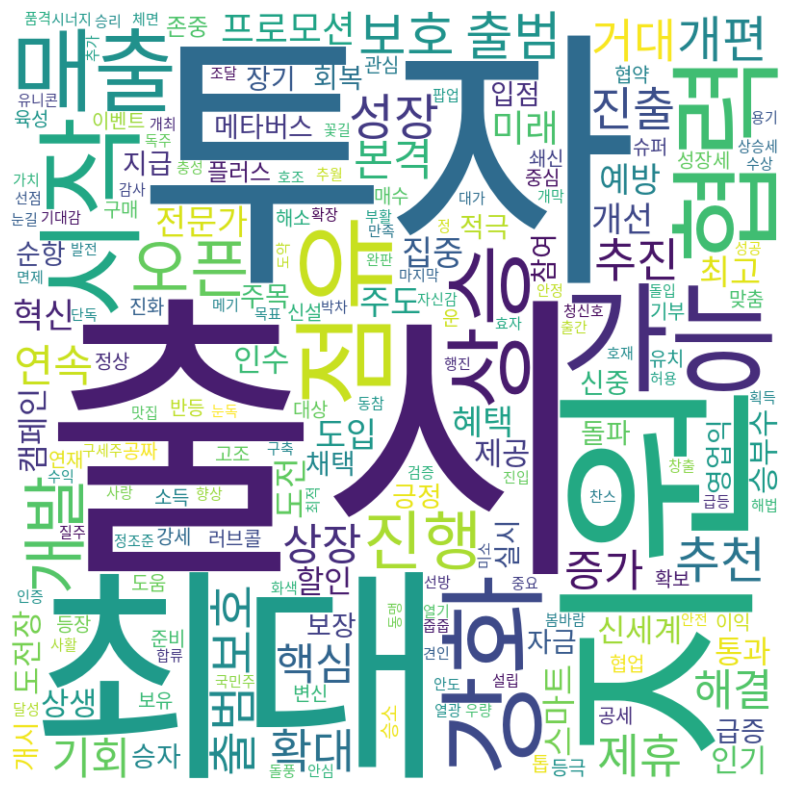

In [18]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(pos_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_pos.png')

In [19]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_pos.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### (2) Neg_Word WordCloud


In [20]:
neg_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Neg_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        neg_data += row['Neg_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
neg_data

'                  위기   급감       논란            논의     환불       과징금   하락     승부    치열             유료 경쟁  의무          갈등     위기       유료  폭증               중단     공격         장벽       갈등  규제        경고 제동          종료   절반    안간힘   수수료    경쟁      중단         하락     차단    약점   게이트  대응            반대          정리  긴장   차별   보증        경쟁     고민      엑스  압박         수준       논란   제한                  착수      벌레      문제   아이 미달  긴장    필요  과점 뒷걸음        적자        논의       하락  악재  맞불 긴장         위협            경쟁      필요                  비교         불황  진심 축소  피해   바닥        비교  태풍   독점                        이탈 고민          패닉  테러 결핵         중단       추격        문제       마감  끝 아이        잰걸음 결실 승부         유료 임박      임박     상한         먹통  공습 논란 중단         변수       악재     하락 마감 매각      경쟁 관건     철회       경쟁   태풍   바람         잰걸음     위험 무산  위험          비교         경쟁                   감내   고민  매도 역대  논의     분쟁                  수준 추격  비용             대전             반토막   비용 문제 위기 격차 거짓         승부 논란     끝          

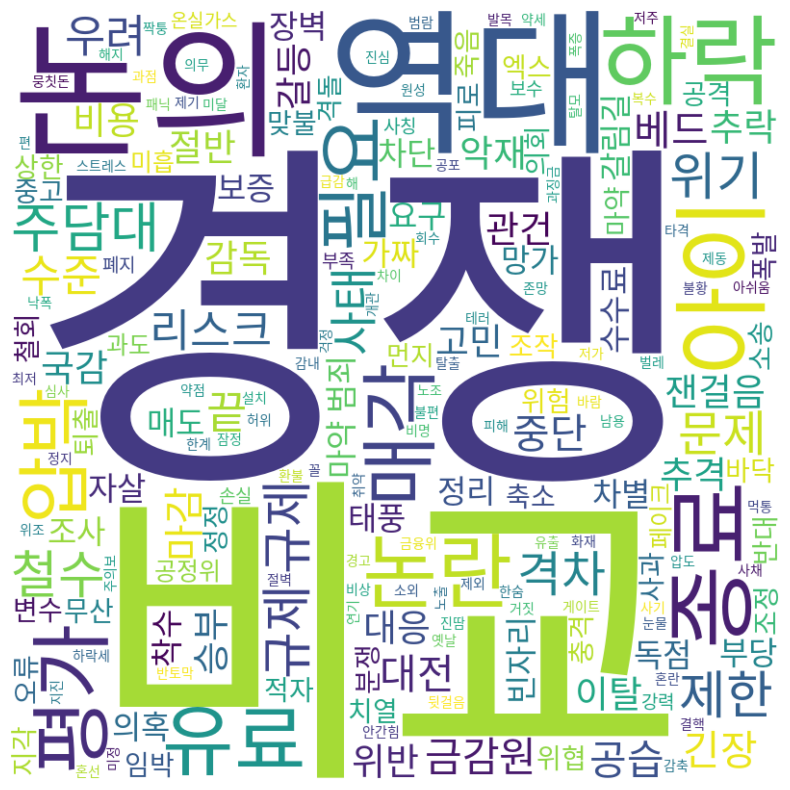

In [21]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(neg_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_neg.png')

In [22]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_neg.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### (3) Zero_Word WordCloud

In [23]:
zero_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Zero_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        zero_data += row['Zero_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
zero_data

'현대차 하이퍼클로바X 시장 연착륙 소년 판타지 나우 아베 방송 동시 중계 오 퀴즈 웨스트 쇼핑 라이브 정답 글로벌 학회 논문 삼성 코스피 에너지 솔루션 주가 태평양 도서 방문 기술 국가 경쟁력 토스 대화 대출 플랫폼 국민 신한은행 까닭 한상혁 다음 손보기 관제 포털 시대 홈 미닉스 미니 건조기 쇼핑 론칭 장례 지도사 웨딩플래너 직업군 카카오 인물 정보 데이터센터 공사 현장 세종 시장 방 큐시트 작성 연내 단장 검색 적용 검토 관련주 엔비디아 발 강풍 미풍 네이버웍스 공공 기관 조달청 디지털 서비스 몰 클라우드 서비스 인사말 후 통계청 장 본사 자회사 그룹 현금 창고 역 한국 경쟁력 삼성 카카오 유튜브 카카오 종이 전자 문서 디지털 환경 종합 사우디 손 국가 수출 검색 왕좌 시장 국민 새벽 사이렌 룰 대학 여행 정보 탐색 인스타 유튜브 서 카카오 스테이지 김장겸 사장 토종 기업 소나기 유튜브 카톡 맹추격 사용자 강 명일 위원장 상업 화제 기반 시각 존재 웹툰 찬반 네이버웹툰 만화 보이콧 행렬 생활 공작 소 세계 환경 기념 그린 쇼핑 위크 참가 웹툰 공개 보이콧 독자 령 으 한국 하이퍼클로바X 활용 서비스 네이버웹툰 사용 가이드라인 웹툰 작가 협의 강점 커머스 분야 플랫폼 선호 쇼핑 라이브 풀럼 코트 품종 구글 광고판 지적 정부 반도체 몰아주기 생성 선 네이버웹툰 정식 연 제작 활용 지양 뉴스 여성신문 구독 아이패드 일본 첨단 기술 수출 원년 소년 판타지 미 방송 아베 공개 포털 메신저 맹추격 구글 팔 카카오 클라우드 보안 계열사 에듀윌 쇼핑 라이브 환급 합격 패스 런 크림 구매자 취소 리셀 플랫폼 재무 법무 밸런스 이사회 한국 시장 메리 슬립 라인 프렌즈 스페셜 에디션 그린 쇼핑 위크 오 퀴즈 안국 건강 미니시리즈 특집 라이브 정답 검색 서 음원 구글 연합 카카오 커넥트 재단 소프트웨어 듀 리뷰 발간 카카오 구글 맹공 카카오 다음 제페토 생성 아바타 광고 녹색 창 카카오 공랭 데이터센터 전기 소모 문화 재단 오늘 세계 주제 연단 시즌 카카오 고리 기술력 실적 

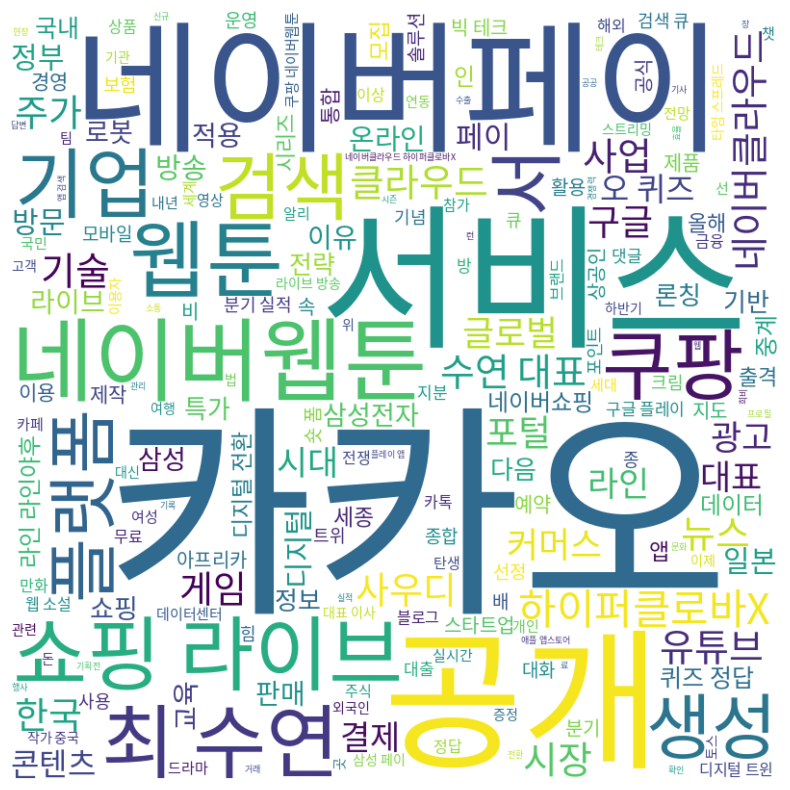

In [24]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(zero_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_zero.png')

In [25]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_zero.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>